# Bayesian parameter estimation for an irregularly, noisily, and partially sampled non-linear SDE (Lorenz 63 w/ diffusion) via auto-differentiable non-linear filtering and HMC

We show how to use the [blackjax](https://github.com/blackjax-devs/blackjax) libray to compute the parameter posterior $p(\theta|y(1:T))$
for non-linear model. We use the Extended Kalman filter to compute the marginal likelihood, $p(y(1:T) | \theta) = \int_{z(1:T)} p(z(1:T), y(1:T)|\theta)$.



## Setup

In [37]:
import sys
%matplotlib inline
sys.path.append("../../..")
sys.path.append("../..")

import dynamax

from jax import numpy as jnp
from jax import vmap
import jax.random as jr
from matplotlib import pyplot as plt


# use custom src codebase
from utils.plotting_utils import *

# from utils.utils import monotonically_increasing
from continuous_discrete_nonlinear_gaussian_ssm import ContDiscreteNonlinearGaussianSSM
from continuous_discrete_nonlinear_gaussian_ssm.models import *

import blackjax


In [38]:
from jax import random as  jr
from jax import numpy as jnp
from jax import jit, vmap
from itertools import count

from dynamax.parameters import log_det_jac_constrain

import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams['figure.figsize'] = [16, 9]

## Generate synthetic training data

In [55]:
# Simulate synthetic data from true model
state_dim = 3
emission_dim = 1
num_sequences = 1
T = 300
num_timesteps = int(T / 0.01)
t_emissions = jnp.array(sorted(jr.uniform(jr.PRNGKey(0), (num_timesteps, 1), minval=0, maxval=T)))
# drop duplicates
t_emissions = jnp.unique(t_emissions)[:,None]
num_timesteps = len(t_emissions)
keys = map(jr.PRNGKey, count())

# Create a model with oscillatory dynamics
## GOAL is to only learn parameters of the drift function and assume all other parameters are known.


dynamics_drift = {
    "params": LearnableLorenz63(sigma=10.0, rho=28.0, beta=8/3),
    "props": LearnableLorenz63(sigma=ParameterProperties(),
                               rho=ParameterProperties(),
                               beta=ParameterProperties()) 
}

dynamics_diffusion_coefficient = {
    "params": LearnableMatrix(params=jnp.eye(state_dim)),
    "props": LearnableMatrix(params=ParameterProperties(trainable=False))
}

dynamics_diffusion_cov = {
    "params": LearnableMatrix(params=jnp.eye(state_dim)),
    "props": LearnableMatrix(params=ParameterProperties(constrainer=RealToPSDBijector(), trainable=False))
}

emission_function = {
    "params": LearnableLinear(weights=jnp.eye(emission_dim, state_dim), bias=jnp.zeros(emission_dim)),
    "props": LearnableLinear(weights=ParameterProperties(trainable=False), bias=ParameterProperties(trainable=False))
}

emission_cov = {
    "params": LearnableMatrix(params=jnp.eye(emission_dim)),
    "props": LearnableMatrix(params=ParameterProperties(constrainer=RealToPSDBijector(), trainable=False))
}

initial_mean = {"params": jnp.zeros(state_dim),
                "props": ParameterProperties(trainable=False)}

initial_cov = {"params": 100*jnp.eye(state_dim),
                "props": ParameterProperties(trainable=False, constrainer=RealToPSDBijector())}


true_model = ContDiscreteNonlinearGaussianSSM(state_dim, emission_dim)
true_params, _ = true_model.initialize(
    next(keys),
    initial_mean=initial_mean,
    initial_cov=initial_cov,
    dynamics_drift=dynamics_drift,
    dynamics_diffusion_coefficient=dynamics_diffusion_coefficient,
    dynamics_diffusion_cov=dynamics_diffusion_cov,
    emission_function=emission_function,
    emission_cov=emission_cov,
)

# sample true states and emissions. Using transition_type="path" to solve SDE.
# true_states, emissions = true_model.sample(true_params, next(keys), num_timesteps, t_emissions)
# true_states, emissions = true_model.sample(true_params, next(keys), num_timesteps, t_emissions, transition_type="path")
true_states, emissions = true_model.sample_batch(
    true_params, next(keys), num_sequences, num_timesteps, t_emissions, transition_type="path"
)

# compute the log likelihood of the true model
## WARNING: only computing it for the first sequence
# this is to avoid batching for now...
first_emissions = emissions[0]
ll_true = true_model.marginal_log_prob(
    params=true_params, filter_hyperparams=EKFHyperParams(), emissions=first_emissions, t_emissions=t_emissions
)
print(f"Log likelihood of true model (approximated by EKF): {-ll_true}")

Sampling from SDE solver path (this may be an unnecessarily poor approximation if you're simulating from a linear SDE). It is an appropriate choice for non-linear SDEs.
Log likelihood of true model (approximated by EKF): 43905.6484375


In [56]:
def plot_results(emissions, smoothed_emissions, smoothed_emissions_std):
    # all arrays are (T, E) dimensional, T=ntime, E=emission_dim
    spc = 3
    plt.figure(figsize=(10, 4))
    for i in range(emission_dim):
        plt.plot(emissions[:, i] + spc * i, "--k", label="observed" if i == 0 else None)
        ln = plt.plot(smoothed_emissions[:, i] + spc * i,
                    label="smoothed" if i == 0 else None)[0]
        plt.fill_between(
            jnp.arange(num_timesteps),
            spc * i + smoothed_emissions[:, i] - 2 * smoothed_emissions_std[:, i],
            spc * i + smoothed_emissions[:, i] + 2 * smoothed_emissions_std[:, i],
            color=ln.get_color(),
            alpha=0.25,
        )
    plt.xlabel("time")
    plt.xlim(0, num_timesteps - 1)
    plt.ylabel("true and predicted emissions")
    plt.legend()

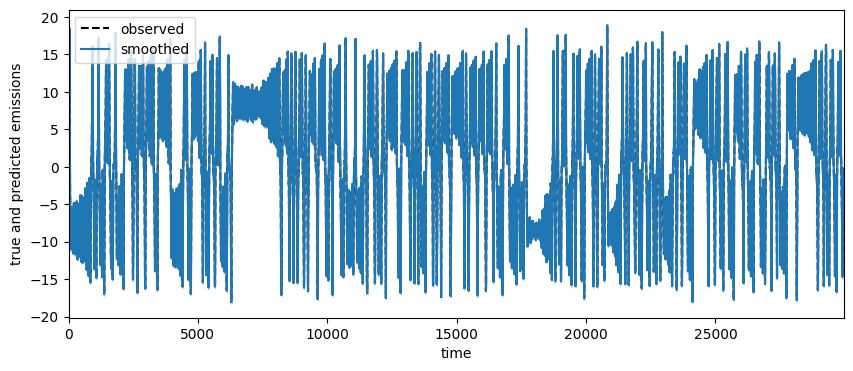

In [57]:
# plot results
plot_results(true_states[0], true_states[0], 0.1 * jnp.ones_like(true_states[0]))  # fake posterior variance

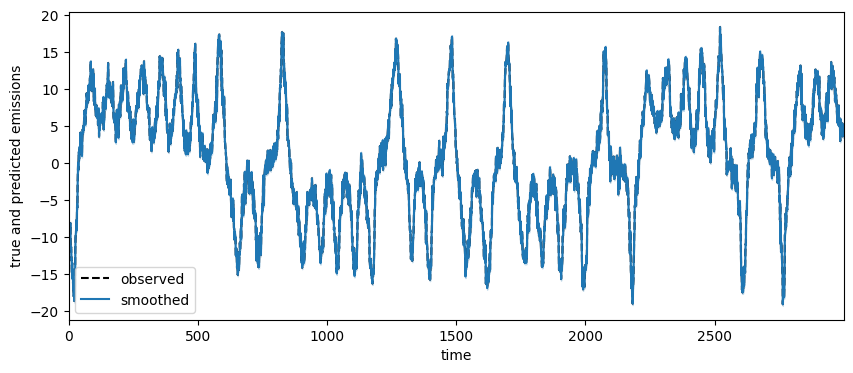

In [42]:
# plot results
plot_results(emissions[0], emissions[0], 0.1 * jnp.ones_like(emissions[0]))  # fake posterior variance

## Create a class for a learnable neural network, which we will use to parameterize the drift function

In [43]:
from typing import NamedTuple, Tuple, Optional, Union
from flax import linen as nn
from jax import jit

@jit
def adjust_rhs(x, rhs, lower_bound=-100, upper_bound=100):
    """
    Adjust the right-hand side of the ODE to ensure that the state 
    remains within the bounds [-100, 100]
    """
    adjust_min = x <= lower_bound
    adjust_max = x >= upper_bound
    rhs = jnp.where(adjust_min, jnp.maximum(rhs, 0), rhs)
    rhs = jnp.where(adjust_max, jnp.minimum(rhs, 0), rhs)
    return rhs


class LearnableNN_TwoLayerGeLU(NamedTuple):
    """Two-layer neural network with Gaussian Error Linear Units
    weights1: weights of the first layer
    bias1: bias of the first layer
    weights2: weights of the second layer
    bias2: bias of the second layer

    f(x) = weights2 @ gelu(weights1 @ x + bias1) + bias2
    """

    weights1: Union[Float[Array, "hidden_dim input_dim"], ParameterProperties]
    bias1: Union[Float[Array, "hidden_dim"], ParameterProperties]
    weights2: Union[Float[Array, "output_dim hidden_dim"], ParameterProperties]
    bias2: Union[Float[Array, "output_dim"], ParameterProperties]

    def f(self, x, u=None, t=None):

        # # first, clamp all x components to be within [-100, 100]
        # x = jnp.clip(x, -100, 100)

        # compute derivative given by NN
        rhs = self.weights2 @ nn.gelu(self.weights1 @ x + self.bias1) + self.bias2

        return adjust_rhs(x, rhs)


## Build initial weights and biases for Neural Network drift function

In [44]:
# Draw weights and biases from a normal distribution with hidden_dim=64, input_dim=state_dim, output_dim=state_dim
hidden_dim = 64
nn_drift = {
    "params": LearnableNN_TwoLayerGeLU(
        weights1=0.01 * jr.normal(next(keys), (hidden_dim, state_dim)),
        bias1=0.01 * jr.normal(next(keys), (hidden_dim,)),
        weights2=0.01 * jr.normal(next(keys), (state_dim, hidden_dim)),
        bias2=0.01 * jr.normal(next(keys), (state_dim,)),
    ),
    "props": LearnableNN_TwoLayerGeLU(
        weights1=ParameterProperties(trainable=True),
        bias1=ParameterProperties(trainable=True),
        weights2=ParameterProperties(trainable=True),
        bias2=ParameterProperties(trainable=True),
    ),
}

## Baseline method: use SGD to compute MLE

In [45]:
# Initilize parameters by fitting SGD algorithm
from continuous_discrete_nonlinear_gaussian_ssm import cdnlgssm_filter
from continuous_discrete_nonlinear_gaussian_ssm import *
from continuous_discrete_nonlinear_gaussian_ssm.models import *
num_epochs = 50

# filter_hyperparams = EnKFHyperParams(N_particles=30)
filter_hyperparams = EKFHyperParams()

test_model = ContDiscreteNonlinearGaussianSSM(state_dim, emission_dim)

initial_params, param_props = test_model.initialize(
    next(keys),
    initial_mean=initial_mean,
    initial_cov=initial_cov,
    dynamics_drift=nn_drift,
    dynamics_diffusion_coefficient=dynamics_diffusion_coefficient,
    dynamics_diffusion_cov=dynamics_diffusion_cov,
    emission_function=emission_function,
    emission_cov=emission_cov,
)

import optax

fitted_params, marginal_lls = test_model.fit_sgd(
    initial_params,
    param_props,
    emissions,
    filter_hyperparams=filter_hyperparams,
    t_emissions=t_emissions,
    num_epochs=num_epochs,
    optimizer=optax.adam(1e-1)
)


In [46]:
# Extract fitted params
fitted_C = fitted_params.emissions.emission_function.weights
fitted_d = fitted_params.emissions.emission_function.bias
fitted_R = fitted_params.emissions.emission_cov.params

# Compute predicted emissions with vmap
filtered_posterior = vmap(
    lambda x: cdnlgssm_filter(fitted_params, emissions=x, hyperparams=filter_hyperparams, t_emissions=t_emissions)
)(emissions)

# filtered_posterior = cdnlgssm_filter(
#     fitted_params, emissions=emissions, hyperparams=filter_hyperparams, t_emissions=t_emissions
# )
filtered_emissions_mean = filtered_posterior.filtered_means @ fitted_C.T + fitted_d

# compute cov and std from this
filtered_emissions_cov = filtered_posterior.filtered_covariances @ fitted_C.T + fitted_R  # (10, 3000, 3, 3)

# use vmap to compute std for each sequence
filtered_emissions_std = vmap(lambda x: jnp.sqrt(jnp.array([x[:, i, i] for i in range(emission_dim)]).T))(filtered_emissions_cov)
# filtered_emissions_std # (10, 3000, 3)
# filtered_emissions_std = jnp.sqrt(jnp.array([filtered_emissions_cov[:, i, i] for i in range(emission_dim)]).T)  # (3, 10, 3)
# Need to compute std for each sequence


# filtered_emissions_cov = fitted_C @ filtered_posterior.filtered_covariances @ fitted_C.T + fitted_R
# filtered_emissions_std = jnp.sqrt(jnp.array([filtered_emissions_cov[:, i, i] for i in range(emission_dim)])).T  # (T,E)

In [47]:
marginal_lls

Array([5.995815], dtype=float32)

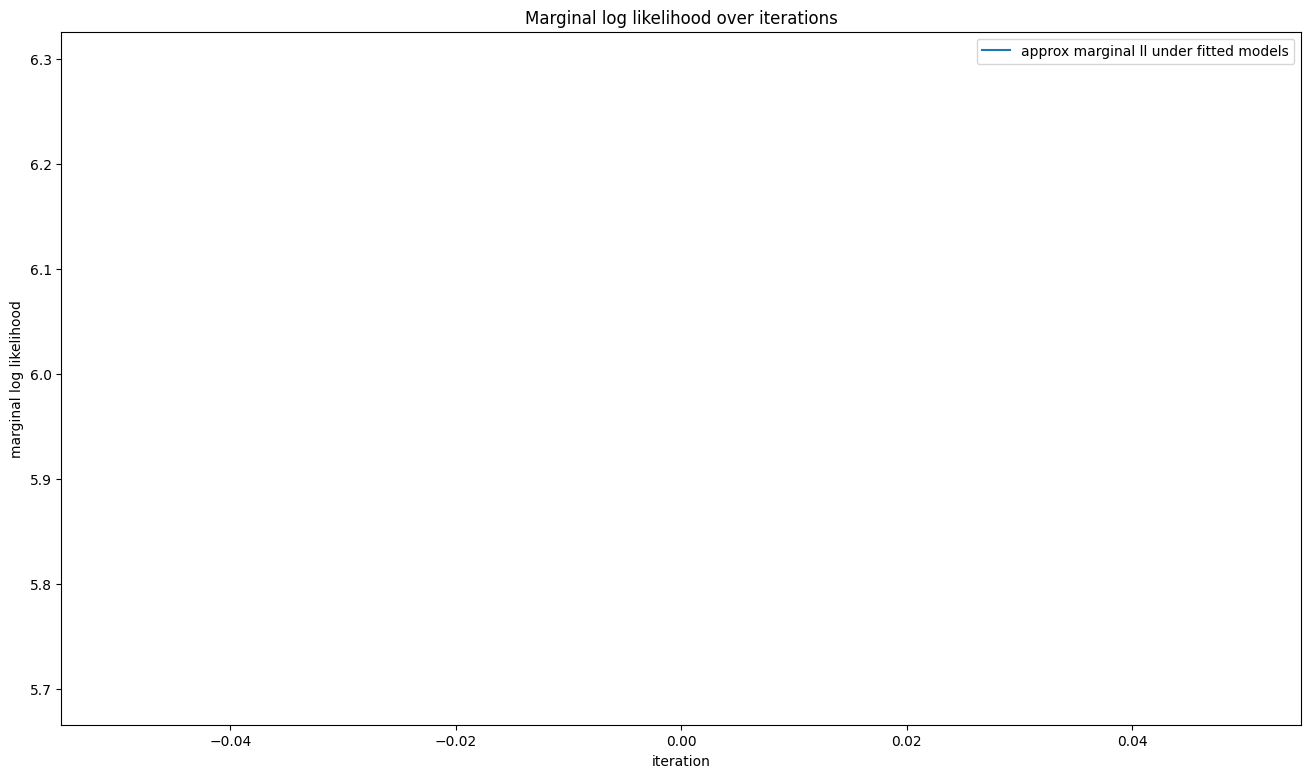

In [48]:
# plot the marginal lls over iterations for SGD
plt.plot(marginal_lls, label="approx marginal ll under fitted models")
# plt.axhline(-ll_true, color="red", linestyle="--", label="approx marginal ll under true model")
plt.xlabel("iteration")
plt.ylabel("marginal log likelihood")
# plt.autoscale(enable=True, axis="x", tight=True)
plt.title("Marginal log likelihood over iterations")
plt.legend()
# plt.yscale("symlog")

[(10, 3000, 1), (10, 3000, 1), (10, 3000, 1)]


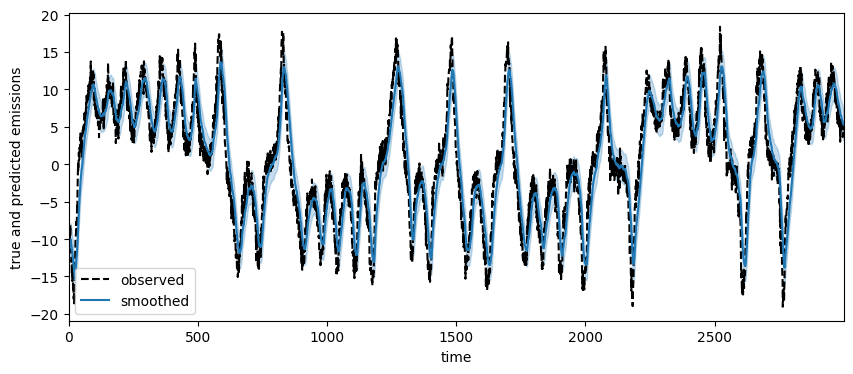

In [49]:
print([emissions.shape, filtered_emissions_mean.shape, filtered_emissions_std.shape])
plot_results(emissions[0], filtered_emissions_mean[0], filtered_emissions_std[0])

Text(0.5, 0, 'time')

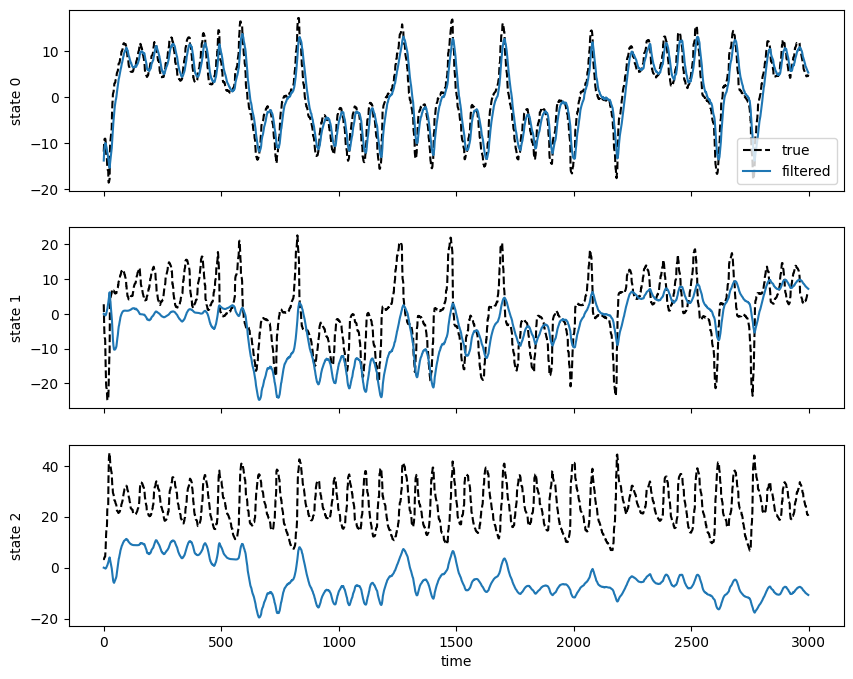

In [50]:
# now plot the true states and the filtered states, each in its own subplot
fig, axs = plt.subplots(state_dim, 1, figsize=(10, 8), sharex=True)
for i in range(state_dim):
    axs[i].plot(true_states[0, :, i], "--k", label="true" if i == 0 else None)
    axs[i].plot(filtered_posterior.filtered_means[0, :, i], label="filtered" if i == 0 else None)
    axs[i].set_ylabel(f"state {i}")
    if i == 0:
        axs[i].legend()
axs[-1].set_xlabel("time")

## Implement HMC wrapper

In [51]:
@jit
def filter_emission(params):
    C = params.emissions.emission_function.weights
    d = params.emissions.emission_function.bias
    filtered_posterior = cdnlgssm_filter(
        params, emissions=emissions[0], hyperparams=filter_hyperparams, t_emissions=t_emissions
    )

    return filtered_posterior.filtered_means @ C.T + d    

In [52]:
import matplotlib.pyplot as plt
import numpy as np


def plot_param_distributions(samples, true, sgd, name='', burn_in_frac=0.5):
    """
    Plots N_params horizontal box plots for the given N_params x N_samples matrix.

    Parameters:
    - samples: N_params x N_samples matrix of parameter samples.
    - true: N_params array of true parameter values.
    - sgd: N_params array of SGD estimates.
    - name: Name of the parameter set.
    - burn_in_frac: Fraction of samples to discard as burn-in.

    Returns:
    - A matplotlib figure with N_params horizontal box plots.
    """
    N_params = samples.shape[0]
    fig, ax = plt.subplots(figsize=(10, N_params * 2))  # Adjust figure size based on number of parameters

    # apply burn-in
    burn_in = int(burn_in_frac * samples.shape[1])
    samples = samples[:, burn_in:]
    
    # Create box plots
    ax.boxplot(samples, vert=False, patch_artist=True)

    # Set the y-axis labels to show parameter indices
    ax.set_yticks(range(1, N_params + 1))
    ax.set_yticklabels(["Parameter {}".format(i + 1) for i in range(N_params)])

    # Plot ground truth and estimates
    ax.scatter(sgd, range(1, N_params + 1), color="magenta", marker="o", s=100, label="SGD Estimate", zorder=3)
    ax.scatter(true, range(1, N_params + 1), color="red", marker="x", s=100, label="Ground Truth", zorder=4)

    plt.xlabel("Value")
    plt.ylabel("Parameters")
    plt.title("{} Parameter Distributions".format(name))
    plt.grid(True)
    plt.legend()
    plt.show()

def plot_all(param_samples, burn_in_frac=0.5):
    """
    Plots the posterior distributions of all parameters.
    Burn-in is removed from the samples.
    """
    plot_param_distributions(
        param_samples.initial.mean.T, true_params.initial.mean, fitted_params.initial.mean, name="Initial mean",
        burn_in_frac=burn_in_frac
    )
    plot_param_distributions(
        param_samples.initial.cov.reshape(param_samples.initial.cov.shape[0], -1).T,
        true_params.initial.cov.flatten(),
        fitted_params.initial.cov.flatten(),
        name="Initial cov",
        burn_in_frac=burn_in_frac,
    )
    plot_param_distributions(
        param_samples.dynamics.drift.sigma.reshape(param_samples.dynamics.drift.sigma.shape[0], -1).T,
        true_params.dynamics.drift.sigma,
        fitted_params.dynamics.drift.sigma,
        name="Dynamics drift sigma",
        burn_in_frac=burn_in_frac,
    )
    plot_param_distributions(
        param_samples.dynamics.drift.rho.reshape(param_samples.dynamics.drift.rho.shape[0], -1).T,
        true_params.dynamics.drift.rho,
        fitted_params.dynamics.drift.rho,
        name="Dynamics drift rho",
        burn_in_frac=burn_in_frac,
    )
    plot_param_distributions(
        param_samples.dynamics.drift.beta.reshape(param_samples.dynamics.drift.beta.shape[0], -1).T,
        true_params.dynamics.drift.beta,
        fitted_params.dynamics.drift.beta,
        name="Dynamics drift beta",
        burn_in_frac=burn_in_frac,
    )
    plot_param_distributions(
        param_samples.dynamics.diffusion_cov.params.reshape(param_samples.dynamics.diffusion_cov.params.shape[0], -1).T,
        true_params.dynamics.diffusion_cov.params.flatten(),
        fitted_params.dynamics.diffusion_cov.params.flatten(),
        name="Dynamics diffusion cov",
        burn_in_frac=burn_in_frac,
    )
    plot_param_distributions(
        param_samples.dynamics.diffusion_coefficient.params.reshape(
            param_samples.dynamics.diffusion_coefficient.params.shape[0], -1
        ).T,
        true_params.dynamics.diffusion_coefficient.params.flatten(),
        fitted_params.dynamics.diffusion_coefficient.params.flatten(),
        name="Dynamics diffusion coefficient",
        burn_in_frac=burn_in_frac,
    )
    plot_param_distributions(
        param_samples.emissions.emission_function.weights.reshape(
            param_samples.emissions.emission_function.weights.shape[0], -1
        ).T,
        true_params.emissions.emission_function.weights.flatten(),
        fitted_params.emissions.emission_function.weights.flatten(),
        name="Emissions function weights",
        burn_in_frac=burn_in_frac,
    )
    plot_param_distributions(
        param_samples.emissions.emission_function.bias.reshape(
            param_samples.emissions.emission_function.bias.shape[0], -1
        ).T,
        true_params.emissions.emission_function.bias.flatten(),
        fitted_params.emissions.emission_function.bias.flatten(),
        name="Emissions function bias",
        burn_in_frac=burn_in_frac,
    )
    plot_param_distributions(
        param_samples.emissions.emission_cov.params.reshape(param_samples.emissions.emission_cov.params.shape[0], -1).T,
        true_params.emissions.emission_cov.params.flatten(),
        fitted_params.emissions.emission_cov.params.flatten(),
        name="Emissions cov",
        burn_in_frac=burn_in_frac,
    )

## Call HMC

In [53]:
# Now, run HMC initialized using the SGD-fitted parameters
# param_samples, lps = test_model.fit_hmc(
#     fitted_params,
#     param_props,
#     emissions,
#     filter_hyperparams,
#     t_emissions,
#     inputs=None,
#     num_samples=500,
#     warmup_steps=10,
#     num_integration_steps=3,
#     key=next(keys)
# )

In [54]:
plt.plot(lps)
plt.xlabel("iteration")
plt.xlabel("log probability")

NameError: name 'lps' is not defined

In [ ]:
filtered_emissions = vmap(filter_emission)(param_samples)
filtered_emissions_mean = filtered_emissions.mean(axis=0)
filtered_emissions_std = jnp.std(filtered_emissions, axis=0)

# note that this shows a distribution of filtered means
# Unlike earlier plots, it does not show the filtered covariances, 
# which would add an appearance of greater uncertainty.
print([emissions.shape, filtered_emissions.shape, filtered_emissions_mean.shape, filtered_emissions_std.shape])
plot_results(emissions, filtered_emissions_mean, filtered_emissions_std)

In [ ]:
plot_all(param_samples)